# Facial Expression Recognition 2023
### Group 15

# 1. Our approach

This project is about creating an algorithm that classifies images of faces into the emotion being expressed. Our approach is to combine the raw pixel feature approach with some of our own extracted edge and spectral features. 

# 2. Our data
## 2.1 Importing the data

In [1]:
## Importing packages

library(tidyverse) # metapackage with lots of helpful functions
library(png) # package that can be used to read png image files in a simple format
library(caret) # package for modelling

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.2     ✔ readr     2.1.4
✔ forcats   1.0.0     ✔ stringr   1.5.0
✔ ggplot2   3.4.2     ✔ tibble    3.2.1
✔ lubridate 1.9.2     ✔ tidyr     1.3.0
✔ purrr     1.0.1     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:purrr’:

    lift


The following object is masked from ‘package:httr’:

    progress




In [2]:
# Show the availabe directories
dirs = dir("../input", pattern="[^g]$", recursive=TRUE, include.dirs = TRUE, full.names = TRUE)
dirs

[1] "../input/bda-2023-facial-expressions"                     
[2] "../input/bda-2023-facial-expressions/ckplus"              
[3] "../input/bda-2023-facial-expressions/ckplus/test"         
[4] "../input/bda-2023-facial-expressions/ckplus/train"        
[5] "../input/bda-2023-facial-expressions/ckplus/train/anger"  
[6] "../input/bda-2023-facial-expressions/ckplus/train/disgust"
[7] "../input/bda-2023-facial-expressions/ckplus/train/happy"  
[8] "../input/bda-2023-facial-expressions/ckplus/train/sadness"

In [3]:
# Get all image files: file names ending ".png" 
anger   = dir(grep("anger",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
disgust = dir(grep("disgust", dirs, value = TRUE), pattern = "png$", full.names = TRUE)
happy   = dir(grep("happy",   dirs, value = TRUE), pattern = "png$", full.names = TRUE)
sad     = dir(grep("sad",     dirs, value = TRUE), pattern = "png$", full.names = TRUE)
test_im = dir(grep("test",    dirs, value = TRUE), pattern = "png$", full.names = TRUE)

# Check file names
str(anger)
str(disgust)
str(happy)
str(sad)
str(test_im)

 chr [1:570] "../input/bda-2023-facial-expressions/ckplus/train/anger/S010_004_00000018a.png" ...
 chr [1:744] "../input/bda-2023-facial-expressions/ckplus/train/disgust/S005_001_00000009a.png" ...
 chr [1:870] "../input/bda-2023-facial-expressions/ckplus/train/happy/S010_006_00000013a.png" ...
 chr [1:354] "../input/bda-2023-facial-expressions/ckplus/train/sadness/S011_002_00000020a.png" ...
 chr [1:1080] "../input/bda-2023-facial-expressions/ckplus/test/S010_004_00000017a.png" ...


## 2.2 Data considerations

Answer the 3 most important questions for any ML project:

1. Where do the data come from? (To which population will results generalize?)

  This data was sampled from the Cohn-Kanade (CK) database and contains grayscale video stills of 101 participants doing 4 facial expressions (happy, angry, sad, disgusted). Participants were 18 to 50 years of age, 69% female, 81%, Euro-American, 13% Afro-American, and 6% other groups (Lucey, et al., 2010; p. 1). Therefore, we can expect generalization to other grayscale images of adult facial expressions from a Euro-American ethnic background. Although, Afro-American and 6% other groups were included, it is unlikely that an algorithm built on this data generalizes to these largely unrepresented populations in the dataset well. Furthermore, these images were cropped to include facial close-ups, therefore similar image preprocessing would enable the best generalizability.
  
2. What are candidate machine learning methods? (models? features?)
   
  Candidate models:
      - multinomial regression with lasso or ridge regularization
      - lda
      - qda
      - classification tree
      - KNN-scaled
      - support vector machines
      - random forests
      - boosted trees      
      
3. What is the Bayes' error bound? (Any guestimate from scientific literature or web resources?)

  This question was answered in the quickstart notebook:
  
  The best 'machine' we have at hand to recognize emotion from facial expression in the human brain. In a study by Mollahosseini et al. (2018) an estimate for human classification inter-rater agreement was obtained for 11 emotions. For the four included in this data set they are:


<table>
    <thead>
    <tr><td>disgust</td><td>anger</td><td>happy</td><td>sad</td></tr>
    </thead>
    <tbody>
        <tr><td>67.6%</td><td>62.3%</td><td>79.6%</td><td>69.7%</td></tr>
    </tbody>
</table>

## 2.3 Formatting Data

We read in our image data pixel by pixel, such that each image is stored as a long vector of pixel intensities, row by row. We also add a vector that contains the emotion label for each of the images.

In [4]:
# Combine all filenames into a single vector
train_image_files = c(anger, happy, sad, disgust)

# Read in the images as pixel values (discarding color channels)
X = sapply(train_image_files, function(nm) c(readPNG(nm)[,,1])) %>% t() 
y = c(rep("anger", length(anger)), rep("happy", length(happy)), rep("sad", length(sad)), rep("disgust", length(disgust)))

X_test = sapply(test_im, function(nm) c(readPNG(nm)[,,1])) %>% t() 


# Change row and column names of X to something more managable (caret::train requires column names)
rownames(X)      = gsub(".+train/", "", rownames(X))
rownames(X_test) = gsub(".+test/",  "", rownames(X_test))

colnames(X) = colnames(X_test) = paste("p",1:ncol(X), sep="")

# Check result (are X, X_test, and y what we expect)
X[1:6,20:23] %>% print # check X
table(y) # check y
                
X_test[1:6,20:23] %>% print # check X_test

                                    p20        p21        p22        p23
anger/S010_004_00000018a.png 0.58039216 0.60784314 0.70196078 0.85882353
anger/S010_004_00000018b.png 0.02745098 0.02745098 0.04313725 0.07450980
anger/S010_004_00000018c.png 0.03529412 0.03137255 0.02745098 0.01960784
anger/S010_004_00000018d.png 0.03921569 0.03137255 0.03137255 0.02745098
anger/S010_004_00000018e.png 1.00000000 1.00000000 1.00000000 1.00000000
anger/S010_004_00000018f.png 1.00000000 1.00000000 1.00000000 1.00000000


y
  anger disgust   happy     sad 
    570     744     870     354 

                              p20        p21        p22        p23
S010_004_00000017a.png 0.77647059 0.81960784 0.89803922 0.98039216
S010_004_00000017b.png 0.46666667 0.52549020 0.63529412 0.74901961
S010_004_00000017c.png 0.25490196 0.34509804 0.49803922 0.67450980
S010_004_00000017d.png 0.04313725 0.03529412 0.03529412 0.02745098
S010_004_00000017e.png 0.03921569 0.03137255 0.03137255 0.02745098
S010_004_00000017f.png 0.07058824 0.10588235 0.14509804 0.24705882


It is always important to have a look at your data. We therefore visualize a sample image below.

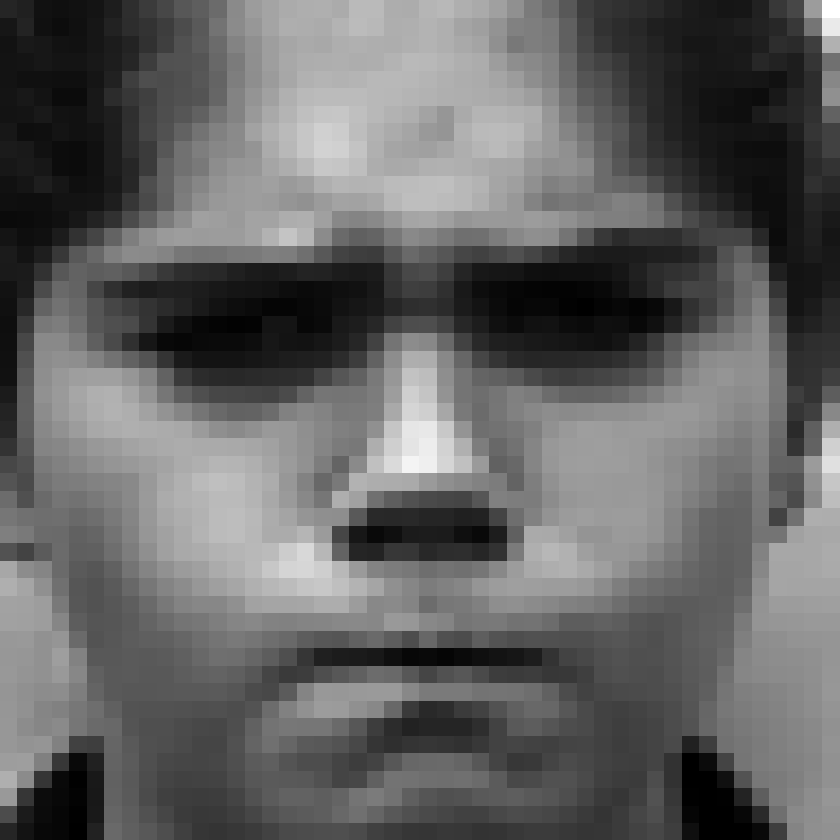

In [5]:
# Visualization utility function
as_image = function(x, nr=sqrt(length(x))) {opar=par(mar=rep(0,4)); on.exit(par(opar)); image(t(matrix(x,nr))[,nr:1], col = gray(0:255/255),axes=F)}

# View image data sample
as_image(X[13,])

# 3. Select informative pixels

In this section we reduce the pixels used as features in our raw pixel data by identifying near zero variance pixels, highly correlated pixels, and any pixels that form linear combinations. We choose pixels with the highest variance, as these likely hold the most information about the differences in facial expression, whereas high correlation and linear combination pixels are removed as they violate model assumptions, such as multicolinearity. We create an index for the pixels that are do not have near zero variance, high correlations, or linear combinations. These are the pixels we then use as features.

## 3.1 Remove near zero variance pixels

We'll define near zero variance as a variance lower than .0475. We calculate pixel variance and select pixels with a chance of being non-zero higher than .95 and lower than .05. This threshold was chosen by visually inspecting the pixels retained. This can be seen in the code below.

In [6]:
# Compute variance of X
var = apply(X,2,var)

# Find pixels that do not have near-zero-variance
use_pix = var > .05 * (1-.05)

# What is the number of pixels retained?
sum(use_pix)

[1] 1548

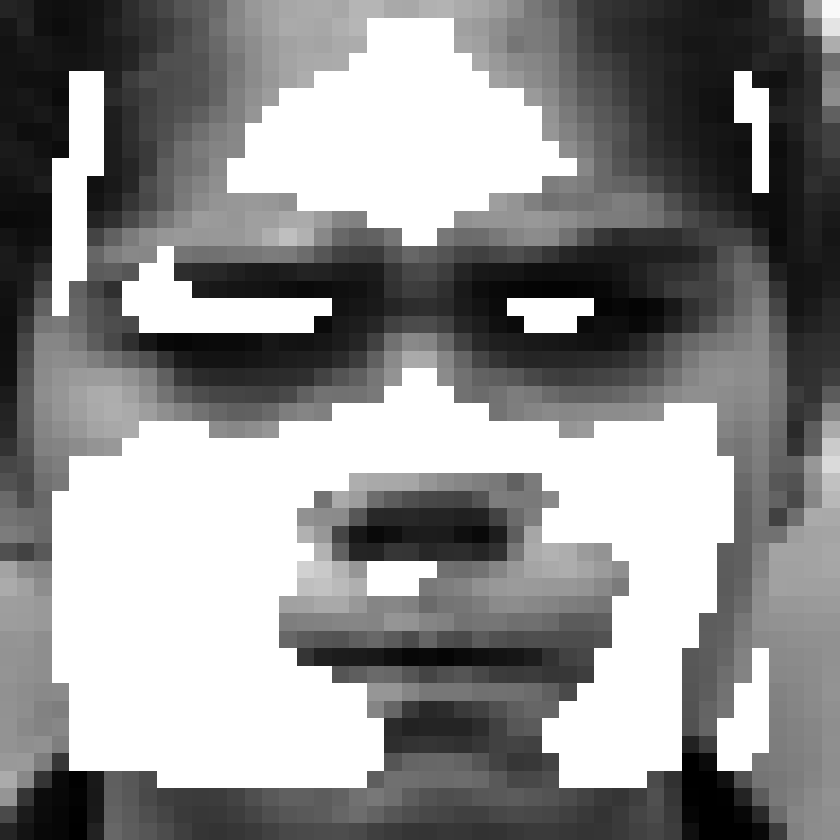

In [7]:
# Visualize the pixels being retained
# Save image to new variable to prevent changing data
img_13 <- X[13,]

# Color unused pixels white
img_13[!use_pix] <- 1 # change pixel value of unused pixels to 1

# View resulting image
as_image(img_13)

## 3.2 Remove pixels with high correlations

Here we identify pixels that have very high correlations. The threshold we use here is again determined by visualizing the pixels retained.

In [8]:
# Find pixels with a very high correlation
high_corr = findCorrelation(cor(X[,use_pix]), .97)

# Are there any high correlations?
print("High correlation pixels in X")
head(high_corr, 20)

# Update use_pix to not include high correlation pixels 
use_pix[use_pix == TRUE][high_corr] <- FALSE

[1] "High correlation pixels in X"


[1]  7  8  9 10 11 12 13 14 15 16 17 18 32 33 34 35 36 55 56 57

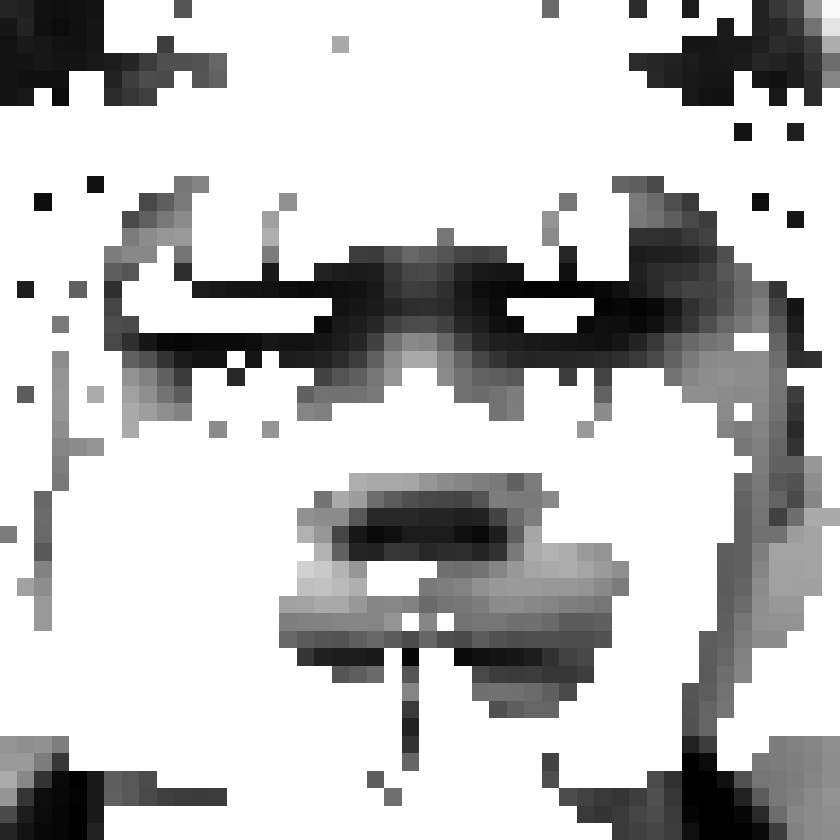

In [9]:
# Visualize pixels being kept
# Color unused pixels white
img_13[!use_pix] <- 1 # change pixel value of unused pixels to 1

# view resulting image
as_image(img_13)

## 3.3 Check for linear combinations

Next we check for linear combinations. There are none present in this data.

In [10]:
# Check for linear combinations
findLinearCombos(X[,use_pix])

$linearCombos
list()

$remove
NULL

In [11]:
# Check dimensions of new data
dim(X[,use_pix])

[1] 2538  827

# 4. Feature extraction
## 4.1 Histogram features from edges

We use the function `get_edge` below, which extracts various histogram features from the horizontal, vertical, and diagonal edges of our images. This function was modified from the notebook [Ekman machine BDA2022 | Team 1](https://www.kaggle.com/code/noahbhat/ekman-machine-bda2022-team-1#2-Features), which is the notebook of the winning competitors of the 2022 competition. Research supports that it is possible to detect facial expressions with good accuracy using edge information (García-Ramírez, Pineda, Olvera-López & Ortiz, 2016).

We choose to calculate various features from these edges including mean, standard deviation, skewness, kurtosis, entropy, bimodality and frey slate features. Most of these features have premade functions, however we need to define two helper functions - `entropy` and `bimodality`, which we can then call in our feature extraction function `get_edge`.

Source

García-Ramírez, J., Pineda, I. O., Olvera-López, J. A., & Ortiz, M. M. (2016). Edge detection for facial expression recognition. *In LANMR* (pp. 66-73).

In [12]:
# Entropy function
entropy <- function(x, 
                    # use Sturges' formula for determining the number of bins or class intervals for a histogram
                    nbreaks = nclass.Sturges(x)) { 
    r <- range(x)
    x_binned <- findInterval(x, seq(r[1], r[2], len = nbreaks))
    h <- tabulate(x_binned, nbins = nbreaks)
    p <- h / sum(h)
    result <- -sum(p[p > 0] * log(p[p > 0]))
    return(result)
}

# Bimodality function
bimodality <- function(x, nbreaks = nclass.Sturges(x)) {
    # create a histogram
    hist_data <- hist(x, breaks = nbreaks, plot = FALSE)
    
    # extract the histogram counts and midpoints
    counts <- hist_data$counts
    midpoints <- hist_data$mids
    
    # find the two highest peaks (modes)
    sorted_counts <- sort(counts, decreasing = TRUE)
    first_mode_count <- sorted_counts[1]
    second_mode_count <- sorted_counts[2]
    
    # calculate the bimodality index based on the relative sizes of the two modes
    bimodality_index <- first_mode_count / (first_mode_count + second_mode_count)
    
    return(bimodality_index)
}

Next we write our edge feature extraction function, which calculates the mentioned histogram features based on different edge types (horizontal, vertical, diagonal) for each image.

In [13]:
# load FreySlateFeatures function 
source("https://bit.ly/32um24j")

# create a function to calculate features for all edges for all training images
get_edge <- function(X, threshold = .0625) {
    
    edge <- function(x) {
        x <- matrix(x, 48) # one image
        output <- edges <- list()
        
        # compute different edges types
        edges[["edge_h"]] <- (x[-1,] - x[-nrow(x),]) # horizontal   
        edges[["edge_v"]] <- (x[,-1] - x[,-ncol(x)]) # vertical
        edges[["edge_d1"]] <- (edges[["edge_h"]][,-1] - edges[["edge_h"]][,-ncol(edges[["edge_h"]])]) # h - v
        edges[["edge_d2"]] <- (edges[["edge_v"]][-1,] - edges[["edge_v"]][-nrow(edges[["edge_v"]]),]) # v - h
    
         # for each edge type
            for (i in c("_h","_v","_d1", "_d2")) {
                
                output[[ paste0("fsf", i) ]] <- FreySlateFeatures(edges[[ paste0("edge", i) ]])
                output[[ paste0("mean", i) ]] <- mean(edges[[ paste0("edge", i) ]])
                output[[ paste0("sd", i) ]] <- sd(edges[[ paste0("edge", i) ]])
                output[[ paste0("entropy", i) ]] <- entropy(edges[[ paste0("edge", i) ]])
                output[[ paste0("bi", i) ]] <- bimodality(edges[[ paste0("edge", i) ]])
                output[[ paste0("kurt", i) ]] <- e1071::kurtosis(edges[[ paste0("edge", i) ]])
                output[[ paste0("skew2", i) ]] <- e1071::skewness(edges[[ paste0("edge", i) ]])
                output[[ paste0("25quantile", i) ]] <- quantile(edges[[ paste0("edge", i) ]], .25)
                output[[ paste0("75quantile", i) ]] <- quantile(edges[[ paste0("edge", i) ]], .75)
                output[[ paste0("min", i) ]] <- min(edges[[ paste0("edge", i) ]])
                output[[ paste0("max", i) ]] <- max(edges[[ paste0("edge", i) ]])
                output[[ paste0("range", i) ]] <-  min(edges[[ paste0("edge", i) ]]) - max(edges[[ paste0("edge", i) ]])
            }
            
            return(unlist(output))
        }
    
    # get edges for all images
    edges <- apply(X, 1, edge)
    
    # transpose 
    return(t(edges))
    }

We can now extract these edge features from our data. We do this for both or train and test data.

In [14]:
# Compute the features for train and test sets
edge_features <- get_edge(X) 
edge_features_test <- get_edge(X_test)

# Check the results
head(edge_features)
dim(edge_features)

,fsf_h.x.box,fsf_h.y.box,fsf_h.width,fsf_h.high,fsf_h.onpix,fsf_h.x.bar,fsf_h.y.bar,fsf_h.x2bar,fsf_h.y2bar,fsf_h.xybar,⋯,sd_d2,entropy_d2,bi_d2,kurt_d2,skew2_d2,25quantile_d2.25%,75quantile_d2.75%,min_d2,max_d2,range_d2
anger/S010_004_00000018a.png,7.978723,8.138298,14.68085,15.00000,7.286102,7.205441,7.403446,3.620597,3.777295,3.668446,⋯,0.05104830,1.2614609,0.5454033,7.648672,0.2360822,-0.01960784,0.01960784,-0.2784314,0.4078431,-0.6862745
anger/S010_004_00000018b.png,7.978723,7.978723,14.68085,14.68085,6.939792,7.209387,7.247603,3.620159,3.618116,3.591863,⋯,0.04795078,1.0127155,0.5701459,11.598449,0.5172207,-0.01568627,0.01568627,-0.3764706,0.4274510,-0.8039216
anger/S010_004_00000018c.png,7.978723,8.138298,14.68085,15.00000,6.865097,7.258741,7.341256,3.621382,3.775385,3.670081,⋯,0.04672045,1.1855539,0.5520540,7.809167,-0.2695963,-0.01568627,0.01960784,-0.3568627,0.3450980,-0.7019608
anger/S010_004_00000018d.png,8.457447,7.978723,14.36170,14.68085,6.810774,6.994176,7.226281,3.466371,3.617566,3.513161,⋯,0.04486086,1.1973967,0.5464541,8.083236,-0.1552267,-0.01568627,0.01568627,-0.3333333,0.3176471,-0.6509804
anger/S010_004_00000018e.png,8.936170,8.617021,14.04255,14.68085,6.919421,6.784770,7.214173,3.316183,3.619816,3.435560,⋯,0.05596869,0.8537955,0.5518072,41.780773,-1.6458989,-0.01960784,0.01960784,-0.9333333,0.4509804,-1.3843137
anger/S010_004_00000018f.png,8.936170,8.138298,14.04255,15.00000,6.817565,6.819334,7.458084,3.313498,3.776609,3.508664,⋯,0.04565286,0.8719850,0.5613787,56.473217,-2.8161857,-0.01568627,0.01960784,-0.8470588,0.2901961,-1.1372549


[1] 2538  108

## 4.2 Spectral features from pixel values

We also chose to extract spectral features from our pixel values, however, prior to computing the features we need to transform our data into the right format.

In [15]:
# Transform X into a long dataframe
X_tibble <- tibble::rownames_to_column(data.frame(X), "id")
X_long <- pivot_longer(X_tibble, cols = !id, names_to = "pixel", values_to = "value")

# Transform X_test into a long dataframe
X_test_tibble <- tibble::rownames_to_column(data.frame(X_test), "id")
X_test_long <- pivot_longer(X_test_tibble, cols = !id, names_to = "pixel", values_to = "value")

# Inspect new data format
head(X_tibble)
head(X_long)

,id,p1,p2,p3,p4,p5,p6,p7,p8,p9,⋯,p2295,p2296,p2297,p2298,p2299,p2300,p2301,p2302,p2303,p2304
,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,anger/S010_004_00000018a.png,0.06666667,0.04705882,0.03529412,0.01960784,0.03137255,0.05490196,0.05882353,0.07450980,0.06666667,⋯,0.007843137,0.00000000,0.09019608,0.6,0.63921569,0.6392157,0.62745098,0.6156863,0.6156863,0.6117647
2,anger/S010_004_00000018b.png,0.06274510,0.07058824,0.07058824,0.05490196,0.03921569,0.03921569,0.03921569,0.04313725,0.04313725,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,1.0000000,1.00000000,1.0000000,1.0000000,1.0000000
3,anger/S010_004_00000018c.png,0.00000000,0.04705882,0.04705882,0.05882353,0.07058824,0.08235294,0.08627451,0.08627451,0.07450980,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,0.9960784,1.00000000,1.0000000,1.0000000,1.0000000
4,anger/S010_004_00000018d.png,1.00000000,0.94901961,0.02352941,0.04313725,0.02745098,0.02745098,0.03529412,0.02745098,0.03137255,⋯,1.000000000,1.00000000,1.00000000,1.0,1.00000000,1.0000000,1.00000000,1.0000000,1.0000000,0.9882353
5,anger/S010_004_00000018e.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,⋯,0.074509804,0.02352941,0.00000000,0.0,0.02352941,0.4509804,0.62745098,0.6274510,0.6235294,0.6117647
6,anger/S010_004_00000018f.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,⋯,0.094117647,0.07843137,0.03921569,0.0,0.00000000,0.0000000,0.02745098,0.5333333,0.6196078,0.6196078


id,pixel,value
<chr>,<chr>,<dbl>
anger/S010_004_00000018a.png,p1,0.06666667
anger/S010_004_00000018a.png,p2,0.04705882
anger/S010_004_00000018a.png,p3,0.03529412
anger/S010_004_00000018a.png,p4,0.01960784
anger/S010_004_00000018a.png,p5,0.03137255
anger/S010_004_00000018a.png,p6,0.05490196


In the following chunk of code we create functions that each extract a different spectral feature using all pixel values per image in our data.

In [16]:
# Spectral entropy 
sp_entropy <- function(x) {
  spec <- spectrum(x, log='n', plot = FALSE)$spec
  entropy(spec)
}

# spectral peak 
sp_peak <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  return(spec$freq[which.max(spec$spec)])
}

# spectral mean 
sp_mean <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  df <- spec$freq[2] - spec$freq[1]
  return(sum(spec$freq * spec$spec * df))
}

# spectral standard deviation 
sp_sd <- function(x) {
  spec <- spectrum(x, plot = FALSE)
  df <- spec$freq[2] - spec$freq[1]
  return(sqrt(sum((spec$freq - sp_mean(x))^2 * spec$spec * df)))
}

# spectral mode
sp_mode <- function(im) {
    spec_features <- spectrum(im, plot = FALSE)
    mode <- max(density(spec_features$freq * spec_features$spec)$x)
    return(mode)
}

# spectral median
sp_median <- function(im) {
    spec_features <- spectrum(im, plot = FALSE)
    median <- median(density(spec_features$freq * spec_features$spec)$x)
    return(median)
}

# spectral kurtosis
sp_kurt <- function(im) {
    spec_features <- spectrum(im, plot = FALSE)
    kurt <- e1071::kurtosis(density(spec_features$freq * spec_features$spec)$y)
    return(kurt)
}

Next we create one big function that calculates our spectral features based on pixel values. This function was derived from a notebook of the 2022 competition - [Group 7: Emotion Recognition 2022](https://www.kaggle.com/code/dorotheehartan/group-7-emotion-recognition-2022)

In [17]:
spectral_f <- function (pictures) {
  pictures %>%
    group_by(id) %>%
    summarise(  
      spectral_entropy = sp_entropy(value), 
      spectral_peak = sp_peak(value),
      spectral_mean = sp_mean(value),
      spectral_sd = sp_sd(value),
      spectral_mode = sp_mode(value),
      spectral_median = sp_median(value),
      spectral_kurt = sp_kurt(value)
    )
}

We now extract these spectral features from our data.

In [18]:
# compute the features for train and test sets
spectral_features <- as.matrix(spectral_f(X_long) %>% select(-id))
spectral_features_test <- as.matrix(spectral_f(X_test_long) %>% select(-id))

# check the results
head(spectral_features)
dim(spectral_features)

spectral_entropy,spectral_peak,spectral_mean,spectral_sd,spectral_mode,spectral_median,spectral_kurt
0.1192106,0.0004340278,0.001477388,0.01357745,0.2738749,0.1367595,333.0694
0.1426195,0.0004340278,0.002093464,0.01968848,0.2523520,0.1259488,284.6838
0.1191358,0.0416666667,0.002526994,0.02039762,0.4337071,0.2166380,215.4078
0.1063805,0.0004340278,0.001937060,0.01869239,0.2168042,0.1082079,295.2168
0.1507307,0.0004340278,0.002966747,0.02289131,0.4422698,0.2209549,232.8463
0.1303368,0.0004340278,0.002793380,0.02090679,0.4691450,0.2344349,247.0783


[1] 2538    7

## 4.3 Binding edge features with spectral features

We now combine our edge and pixel histogram features into one feature matrix.

In [19]:
# Bind feature matrices
edge_spec_features <- edge_features %>%
    cbind(spectral_features)
edge_spec_features_test <- edge_features_test %>%
    cbind(spectral_features_test)

# Inspect feature data
head(edge_spec_features)
head(edge_spec_features_test)
dim(edge_spec_features)

,fsf_h.x.box,fsf_h.y.box,fsf_h.width,fsf_h.high,fsf_h.onpix,fsf_h.x.bar,fsf_h.y.bar,fsf_h.x2bar,fsf_h.y2bar,fsf_h.xybar,⋯,min_d2,max_d2,range_d2,spectral_entropy,spectral_peak,spectral_mean,spectral_sd,spectral_mode,spectral_median,spectral_kurt
anger/S010_004_00000018a.png,7.978723,8.138298,14.68085,15.00000,7.286102,7.205441,7.403446,3.620597,3.777295,3.668446,⋯,-0.2784314,0.4078431,-0.6862745,0.1192106,0.0004340278,0.001477388,0.01357745,0.2738749,0.1367595,333.0694
anger/S010_004_00000018b.png,7.978723,7.978723,14.68085,14.68085,6.939792,7.209387,7.247603,3.620159,3.618116,3.591863,⋯,-0.3764706,0.4274510,-0.8039216,0.1426195,0.0004340278,0.002093464,0.01968848,0.2523520,0.1259488,284.6838
anger/S010_004_00000018c.png,7.978723,8.138298,14.68085,15.00000,6.865097,7.258741,7.341256,3.621382,3.775385,3.670081,⋯,-0.3568627,0.3450980,-0.7019608,0.1191358,0.0416666667,0.002526994,0.02039762,0.4337071,0.2166380,215.4078
anger/S010_004_00000018d.png,8.457447,7.978723,14.36170,14.68085,6.810774,6.994176,7.226281,3.466371,3.617566,3.513161,⋯,-0.3333333,0.3176471,-0.6509804,0.1063805,0.0004340278,0.001937060,0.01869239,0.2168042,0.1082079,295.2168
anger/S010_004_00000018e.png,8.936170,8.617021,14.04255,14.68085,6.919421,6.784770,7.214173,3.316183,3.619816,3.435560,⋯,-0.9333333,0.4509804,-1.3843137,0.1507307,0.0004340278,0.002966747,0.02289131,0.4422698,0.2209549,232.8463
anger/S010_004_00000018f.png,8.936170,8.138298,14.04255,15.00000,6.817565,6.819334,7.458084,3.313498,3.776609,3.508664,⋯,-0.8470588,0.2901961,-1.1372549,0.1303368,0.0004340278,0.002793380,0.02090679,0.4691450,0.2344349,247.0783


,fsf_h.x.box,fsf_h.y.box,fsf_h.width,fsf_h.high,fsf_h.onpix,fsf_h.x.bar,fsf_h.y.bar,fsf_h.x2bar,fsf_h.y2bar,fsf_h.xybar,⋯,min_d2,max_d2,range_d2,spectral_entropy,spectral_peak,spectral_mean,spectral_sd,spectral_mode,spectral_median,spectral_kurt
S010_004_00000017a.png,7.978723,8.138298,14.68085,15.00000,7.347216,7.217915,7.408142,3.620616,3.776851,3.668110,⋯,-0.2784314,0.4274510,-0.7058824,0.12173762,0.0004340278,0.001483003,0.01357468,0.2987645,0.1492058,252.4360
S010_004_00000017b.png,7.659574,7.978723,14.04255,14.68085,6.871888,6.937648,7.248499,3.314523,3.619147,3.434284,⋯,-0.3882353,0.4274510,-0.8156863,0.08906895,0.0416666667,0.002930787,0.02239665,0.6322154,0.3158803,240.5441
S010_004_00000017c.png,8.936170,8.138298,14.04255,15.00000,6.797193,6.825170,7.443053,3.313871,3.776168,3.509054,⋯,-0.2509804,0.3764706,-0.6274510,0.14145278,0.0004340278,0.002707822,0.02088621,0.3404470,0.1700569,221.1976
S010_004_00000017d.png,8.457447,7.659574,14.36170,14.04255,6.661385,6.989553,6.945403,3.466538,3.311097,3.361009,⋯,-0.3450980,0.5019608,-0.8470588,0.11946165,0.0004340278,0.002736302,0.02512135,0.2411207,0.1202992,213.4516
S010_004_00000017e.png,8.936170,7.978723,14.04255,14.68085,6.613852,6.801357,7.267184,3.313487,3.617753,3.437410,⋯,-0.3254902,0.4745098,-0.8000000,0.15606293,0.0004340278,0.002813014,0.02082563,0.3338763,0.1667096,370.2161
S010_004_00000017f.png,7.978723,8.138298,14.68085,15.00000,7.286102,7.264513,7.383922,3.622074,3.776312,3.669621,⋯,-0.2588235,0.3333333,-0.5921569,0.13377962,0.0416666667,0.002190686,0.01887423,0.2714152,0.1355152,411.1166


[1] 2538  115

In [20]:
# Check that row names match original
unique(rownames(X) == rownames(edge_spec_features))

[1] TRUE

## 4.4 Select informative features

For similar reasons as with our raw pixel data, we identify near zero variance, highly correlated, and linear combination features from our edge and spectral features. We will again create an index variable, `use_ft`, which will indicate the features to fit our models with.

### Near zero variance

Since we have far fewer edge and spectral features than pixels, we can use the "slower" caret function `nearZeroVar` to identify our near zero variance features.

In [21]:
# store indices of near zero variance features
drop_nearZeroVar <- caret::nearZeroVar(edge_spec_features) # no near zero variance features

# create vector of indices to keep
use_ft <- !colnames(edge_spec_features) %in% drop_nearZeroVar

### High correlations

In [22]:
# find features with a very high correlation
high_corr = findCorrelation(cor(edge_spec_features[,use_ft]), .9)

# are there any high correlations?
print("High correlation features")
head(high_corr, 20)

# update use_ft to not include high correlation features 
use_ft[use_ft == TRUE][high_corr] <- FALSE

# What is the number of features retained?
sum(use_ft)

[1] "High correlation features"


[1]  8  9 11 12 35 36 38 39 62 63 65 66 84 85 86 87 88 89 90 91

[1] 58

### Linear combinations

In [23]:
# Check for linear combinations
linear_combos <- findLinearCombos(edge_spec_features[,use_ft])
drop_linear_combos <- linear_combos$remove

# update use_ft to not include linear combination features
use_ft[use_ft == TRUE][drop_linear_combos] <- FALSE

# What is the number of features retained?
sum(use_ft)

[1] 55

## 4.5 Binding raw pixel, edge, and spectral features

Now that we have identified informative and usable features from both our raw pixels, edge features, and spectral features, we can combine these into one matrix.

In [24]:
# Bind all features into one matrix
all_features <-  cbind(X[,use_pix], edge_spec_features[,use_ft])
all_features_test <- cbind(X_test[,use_pix], edge_spec_features_test[,use_ft])

# Inspect data
head(all_features)

,p1,p2,p3,p4,p5,p6,p31,p43,p44,p45,⋯,25quantile_d2.25%,75quantile_d2.75%,min_d2,max_d2,spectral_entropy,spectral_peak,spectral_mean,spectral_sd,spectral_median,spectral_kurt
anger/S010_004_00000018a.png,0.06666667,0.04705882,0.03529412,0.01960784,0.03137255,0.05490196,0.49411765,0.7843137,0.8078431,0.8627451,⋯,-0.01960784,0.01960784,-0.2784314,0.4078431,0.1192106,0.0004340278,0.001477388,0.01357745,0.1367595,333.0694
anger/S010_004_00000018b.png,0.06274510,0.07058824,0.07058824,0.05490196,0.03921569,0.03921569,0.02745098,0.8862745,0.8784314,0.8745098,⋯,-0.01568627,0.01568627,-0.3764706,0.4274510,0.1426195,0.0004340278,0.002093464,0.01968848,0.1259488,284.6838
anger/S010_004_00000018c.png,0.00000000,0.04705882,0.04705882,0.05882353,0.07058824,0.08235294,0.20392157,0.7803922,0.8352941,0.8705882,⋯,-0.01568627,0.01960784,-0.3568627,0.3450980,0.1191358,0.0416666667,0.002526994,0.02039762,0.2166380,215.4078
anger/S010_004_00000018d.png,1.00000000,0.94901961,0.02352941,0.04313725,0.02745098,0.02745098,0.45098039,0.1764706,0.6705882,0.7725490,⋯,-0.01568627,0.01568627,-0.3333333,0.3176471,0.1063805,0.0004340278,0.001937060,0.01869239,0.1082079,295.2168
anger/S010_004_00000018e.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.0000000,1.0000000,1.0000000,⋯,-0.01960784,0.01960784,-0.9333333,0.4509804,0.1507307,0.0004340278,0.002966747,0.02289131,0.2209549,232.8463
anger/S010_004_00000018f.png,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,1.00000000,0.99607843,0.4000000,0.6745098,0.8196078,⋯,-0.01568627,0.01960784,-0.8470588,0.2901961,0.1303368,0.0004340278,0.002793380,0.02090679,0.2344349,247.0783


# 5. Model fitting

In section 2.2 Data considerations, we identified several potential models for this classification problem. We fitted several of these models to the data: Classification Trees, Random Forests, k-Nearest Neighbors, Boosted Trees, Multinomial Regression with Lasso and Ridge Regularization, Support Vector Machines and Linear Discriminant Analysis with PCA preprocessing. Each of these models we originally fitted on the raw pixels - both using the full image size and 2x2 pooled image size - as well as on the edge and spectral features. However, for our final notebook we used a dataframe with the raw pixels (full size) and the calculated features combined. We removed the models fitted on the raw pixels and features separately, since these performed worse based on model accuracy estimates. 

## 5.1 Splitting train and validation set

To standardize our estimation of model accuracy, we decided to apply a validation set approach to all models. We splitted our train data into a train and validation set, and calculated our accuracy on the validation set. 

Below we sampled 80% of our train data to get our train indices, `train_idx`. The validation set can be indexed by removing rather than selecting train indices.

In [25]:
# Create train set indices
set.seed(2023) # set seed for reproducibility
train_idx <- sample(1:nrow(all_features), # sample from all images
                    size = round(0.8 * nrow(all_features))) # take a sample 80% of the full train data

## 5.2 Classification tree models

We started by fitting classification tree models, which fit a single tree to the data in order to classify data points into classes. For our final notebook, we fitted a classification tree model on all features combined. We deployed 5-fold cross-validation to tune the complexity parameter. Cross-validation also produces models more robust against over-fitting. 

In [26]:
# Use multiple cores whenever possible
doMC::registerDoMC(cores = 4) 

# Train control object for 5-fold cross-validation 
set.seed(2023)
trCntrl <-  trainControl('cv', 5, allowParallel = TRUE)

In [27]:
# Classification tree 
fit_tree <- train(x = all_features[train_idx,], # train model on 80% of samples in the feature matrix
                  y = y[train_idx], 
                  method='rpart',
                  trControl = trCntrl, 
                  tuneGrid = data.frame(cp=.02))
# View model
fit_tree

CART 

2030 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1624, 1624, 1624, 1624, 1624 
Resampling results:

  Accuracy   Kappa    
  0.5034483  0.2932734

Tuning parameter 'cp' was held constant at a value of 0.02

Here we view what features the decision tree is using to categorise the images, which can give insights into key features for our models. We can see that both calculated and pixel features are being used by the classification tree.

n= 2030 

node), split, n, loss, yval, (yprob)
      * denotes terminal node

 1) root 2030 1332 happy (0.22610837 0.29605911 0.34384236 0.13399015)  
   2) 75quantile_d2.75%< 0.01960784 1107  707 disgust (0.32610659 0.36133695 0.15718157 0.15537489)  
     4) fsf_v.x.ege< 28.46135 596  302 disgust (0.28187919 0.49328859 0.11073826 0.11409396) *
     5) fsf_v.x.ege>=28.46135 511  318 anger (0.37769080 0.20743640 0.21135029 0.20352250) *
   3) 75quantile_d2.75%>=0.01960784 923  399 happy (0.10617551 0.21776815 0.56771398 0.10834236)  
     6) p1617>=0.6647059 524  316 happy (0.15839695 0.31488550 0.39694656 0.12977099)  
      12) p1621>=0.5509804 428  268 disgust (0.18224299 0.37383178 0.28971963 0.15420561)  
        24) p1532< 0.7392157 224  120 disgust (0.21428571 0.46428571 0.09375000 0.22767857) *
        25) p1532>=0.7392157 204  101 happy (0.14705882 0.27450980 0.50490196 0.07352941) *
      13) p1621< 0.5509804 96   12 happy (0.05208333 0.05208333 0.87500000 0.02083333) *
     

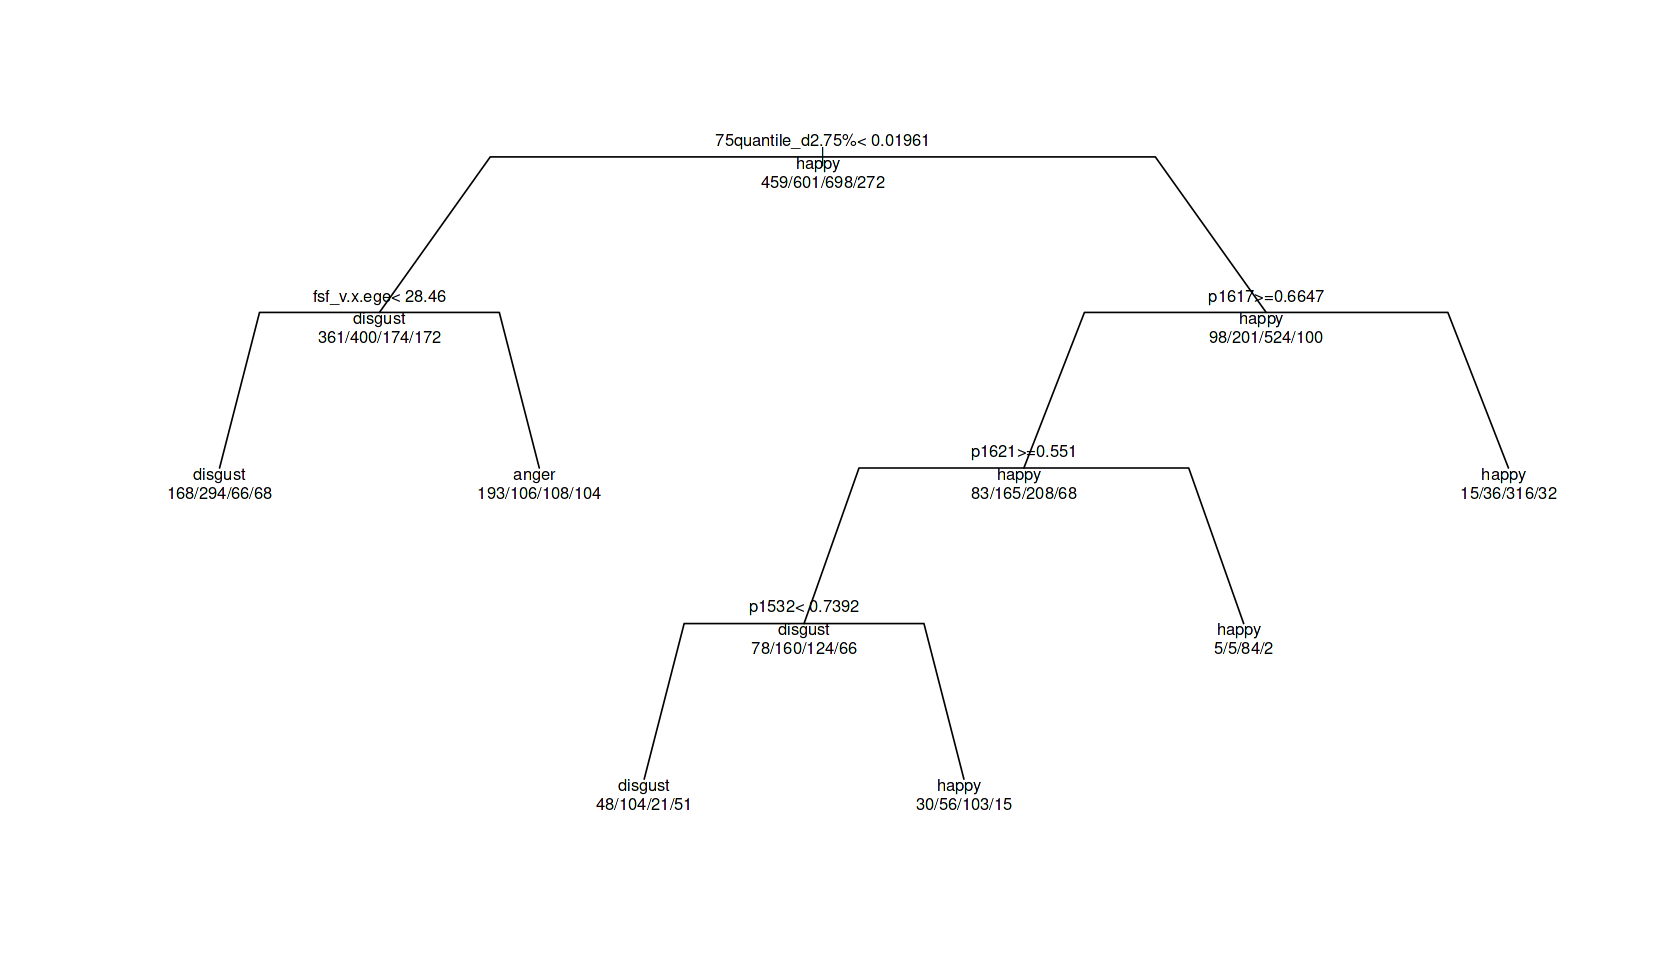

In [28]:
## Graphical visualization of the decision tree
options(repr.plot.width = 14, repr.plot.height = 8)
plot(fit_tree$final, compress = TRUE, uniform = TRUE, margin = 0.05, branch = .75); 
text(fit_tree$final, cex = 0.8, all = TRUE, use.n = TRUE)

## Textual visualization of the decision tree
fit_tree$finalModel

## 5.3 Random Forest

Classification trees use a single decision tree for classification, making it sensitive to overfitting. With Random Forests multiple different decision trees are used to make the predictions, making it less sensitive to overfitting. We fitted a random forest model to our combined features data using 5-fold cross-validation to get a more robust estimate of the model's performance.

In [29]:
# TrainControl object for 5-fold cross-validation 
set.seed(2023)
trControl_rf <- trainControl(method = "cv",      # Cross-validation
                             number = 5,         # 5-fold
                             verboseIter = TRUE, # Display progress
                             allowParallel = TRUE)

In [30]:
# Random forest with CV 
fit_rf_cv <- train(x = all_features[train_idx,], 
                   y = y[train_idx], method = 'rf', 
                   trControl = trControl_rf, 
                   tuneGrid = data.frame(mtry = 9))

# View model
fit_rf_cv$finalModel

Aggregating results
Fitting final model on full training set



Call:
 randomForest(x = x, y = y, mtry = param$mtry) 
               Type of random forest: classification
                     Number of trees: 500
No. of variables tried at each split: 9

        OOB estimate of  error rate: 13.55%
Confusion matrix:
        anger disgust happy sad class.error
anger     352      81    15  11  0.23311547
disgust    27     531    41   2  0.11647255
happy       1       6   691   0  0.01002865
sad        39      49     3 181  0.33455882

## 5.4 KNN

As opposed to classification trees and random forests, k-Nearest Neighbors classifies points to a class to which it's K nearest neighbors also (mostly) belong. We wanted to investigate the classification of this model and compare it to the other models. We fitted KNN models to the data in which we standardized the features, to ensure that some features do not have a greater influence on the model's calculations than others. Again, we used 5-fold cross-validation on this model. 

In [31]:
# Set seed for reproducibility
set.seed(2023)

# KNN with scaling the features 
fit_knns <- train(all_features[train_idx,], 
                  y[train_idx], 
                  method = 'knn', 
                  trControl = trCntrl, 
                  preProcess = "scale")
# View model
fit_knns

k-Nearest Neighbors 

2030 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

Pre-processing: scaled (882) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1624, 1624, 1624, 1624, 1624 
Resampling results across tuning parameters:

  k  Accuracy   Kappa    
  5  0.6088670  0.4578529
  7  0.6246305  0.4793672
  9  0.6334975  0.4899707

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was k = 9.

## 5.5 Boosted tree

Boosted trees expand on random forests in that they also use multiple decision trees, but boosted trees build these trees in a sequential manner. This (potentially) leads to a better model performance, though boosted trees are also more prone to overfitting. We used 5-fold cross-validation in fitting the boosted tree model. 

In [32]:
# Set seed for reproducibility
set.seed(2023)  

# boosted tree 
fit_xgb = train(x = all_features[train_idx,], 
                y = y[train_idx], method = "xgbTree", 
                trControl = trCntrl, 
                tuneGrid = data.frame(nrounds = 600, 
                                      max_depth = 4, 
                                      eta = .3, 
                                      gamma = 0, 
                                      colsample_bytree = 0.95, 
                                      min_child_weight = 1, 
                                      subsample = 1))
# View model
fit_xgb

eXtreme Gradient Boosting 

2030 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1624, 1624, 1624, 1624, 1624 
Resampling results:

  Accuracy   Kappa    
  0.9147783  0.8821889

Tuning parameter 'nrounds' was held constant at a value of 600
Tuning
 held constant at a value of 1
Tuning parameter 'subsample' was held
 constant at a value of 1

## 5.6 Multinomial regression
### 5.6.1 Lasso regression

We fitted a multinomial regression model with a Lasso penalty on the combined (raw pixels and features) data. Lasso shrinks coefficients of unimportant features in the model to exactly zero. This method reduces the amount of features used by the model, which is helpful in our case, since due to the raw pixel features included we have around 800 features.

Loading required package: Matrix


Attaching package: ‘Matrix’


The following objects are masked from ‘package:tidyr’:

    expand, pack, unpack


Loaded glmnet 4.1-7



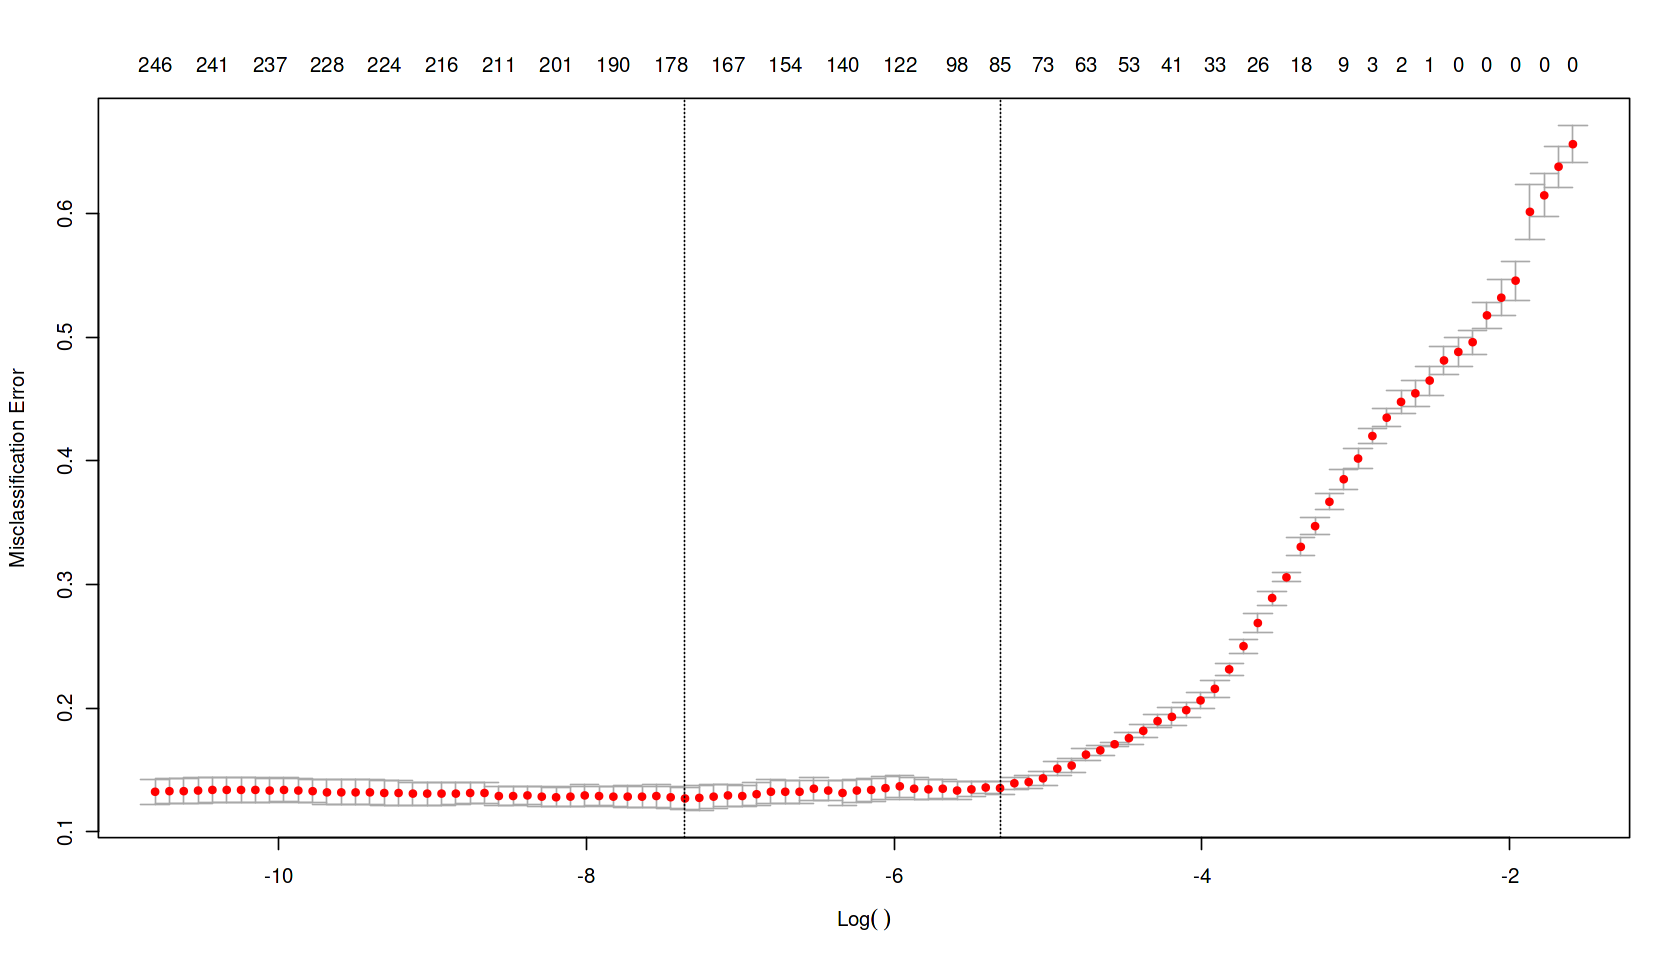

In [33]:
# Lasso multinomial regression 
set.seed(2023)
fit_lasso <- glmnet::cv.glmnet(all_features[train_idx,], 
                                 y[train_idx], 
                                 family = "multinomial",
                                 nfolds = 5, # 5 fold cross-validation
                                 alpha = 1, 
                                 type.measure = "class",
                                 parallel = TRUE,
                                 standardize = TRUE)
# Plot model
plot(fit_lasso)

### 5.7.2 Ridge regression

We also fitted a multinomial regression model with a Ridge penalty on the combined (raw pixels and features) data. Ridge shrinks coefficients of unimportant features towards zero, though these coefficients will never be exactly zero.

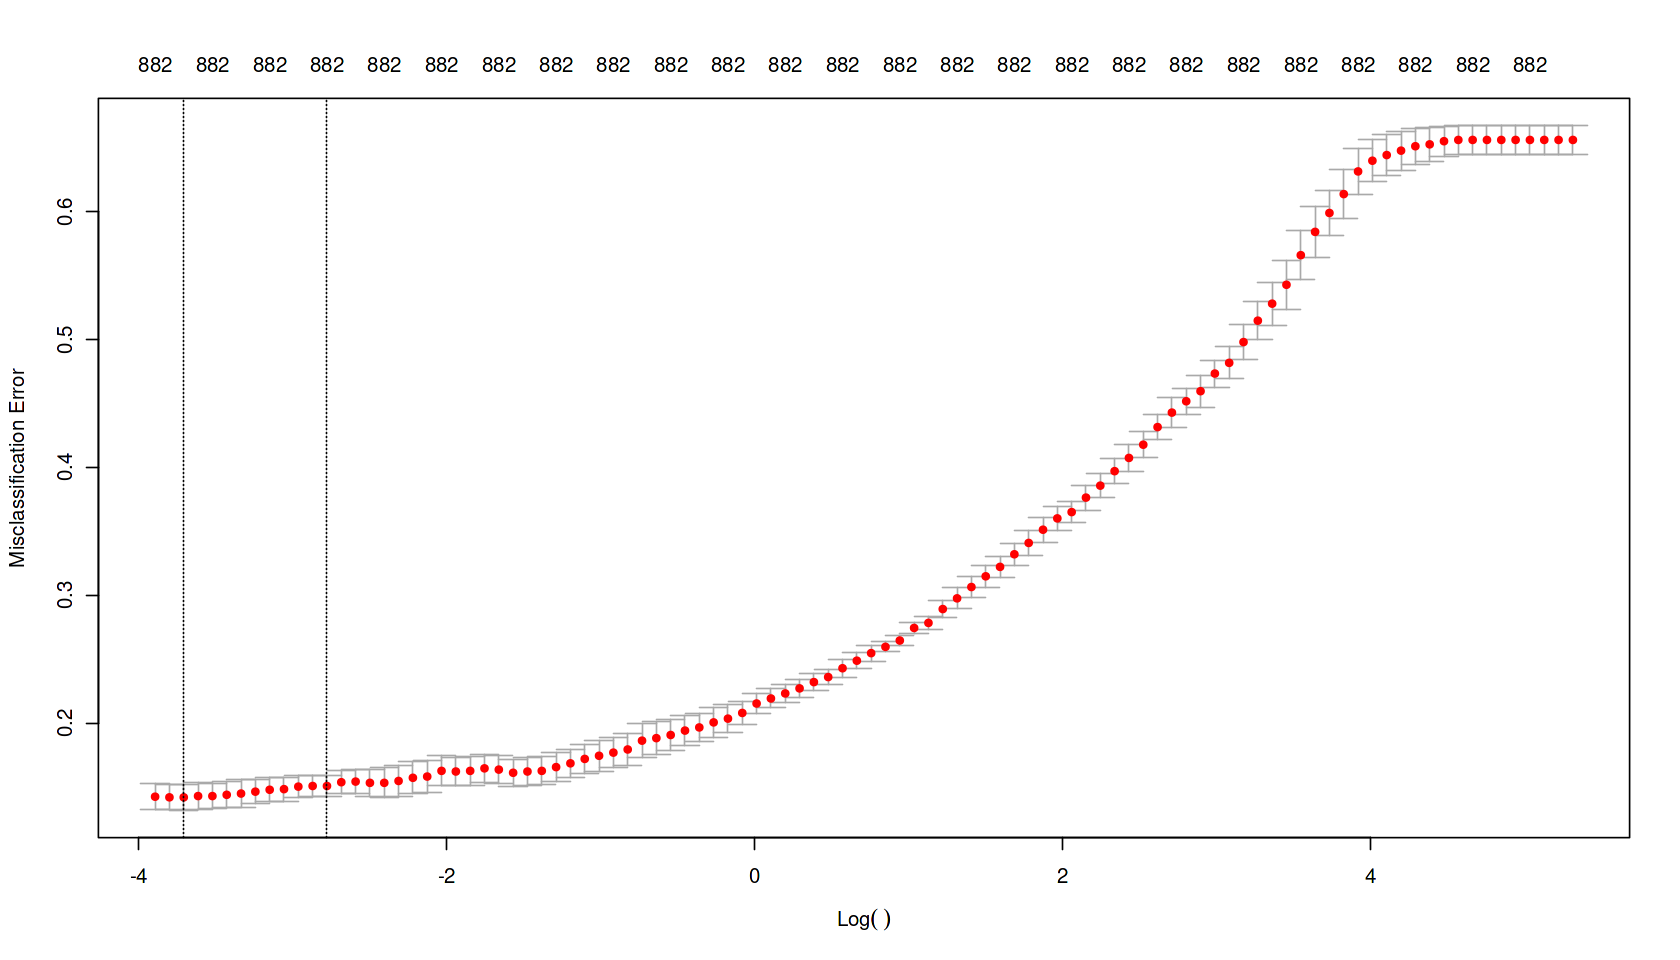

In [34]:
# Ridge multinomial regression
set.seed(123)
fit_ridge <- glmnet::cv.glmnet(all_features[train_idx,], 
                               y[train_idx], 
                               family = "multinomial",
                               nfolds = 5,
                               alpha = 0, 
                               type.measure = "class",
                               parallel = TRUE,
                               standardize = TRUE)

# Plot model
plot(fit_ridge)

## 5.8 Support Vector Machine

We fitted a support vector machine to the combined (raw pixels and features) data. SVMs classifies the data into classes by determining the optimal hyperplane that separates the data points. We tried several different kernels: linear, sigmoid and radial, although we only included the best performing of these in the final notebook for computation time reasons. The SVM with the radial kernel had the best performance, which makes sense because there are non-linear relationships in the data and the boundary between classes is therefore more complex, which the radial kernel can capture well. Also with this model we adopted 5-fold cross-validation. 

In [35]:
# Set seed for reproducibility
set.seed(2023)

# Support vector machine 
fit_svm <- train(x = all_features[train_idx,], 
                  y = y[train_idx], 
                  method = "svmRadial", 
                  trCntrl = trCntrl,
                  preProcess = c("center","scale"), 
                  tuneLength = 10)
# View model
fit_svm 

Support Vector Machines with Radial Basis Function Kernel 

2030 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

Pre-processing: centered (882), scaled (882) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2030, 2030, 2030, 2030, 2030, 2030, ... 
Resampling results across tuning parameters:

  C       Accuracy   Kappa    
    0.25  0.7268345  0.6129013
    0.50  0.8182080  0.7459770
    1.00  0.8689307  0.8178687
    2.00  0.8980110  0.8586548
    4.00  0.9160189  0.8837816
    8.00  0.9207154  0.8903381
   16.00  0.9198640  0.8891762
   32.00  0.9198538  0.8891594
   64.00  0.9198538  0.8891594
  128.00  0.9198538  0.8891594

Tuning parameter 'sigma' was held constant at a value of 0.0006778483
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.0006778483 and C = 8.

## 5.9 LDA with PCA

Lastly, we did a Linear Discriminant Analysis of our combined (raw pixels and features) data with dimension reduction by means of Principal Component Analysis as a preprocessing step. Though our data is presumably not linearly separable, we were still interested in the outcomes this model would produce. We fitted the LDA model using 5-fold cross-validation. 

In [36]:
# Set seed for reproducibility
set.seed(2023)  

# Fit LDA
fit_lda <- train(x = all_features[train_idx,], 
                 y = y[train_idx], # y_sample as factor 
                 method = 'lda', 
                 trControl = trCntrl,
                 preProcess = "pca")
# View model
fit_lda

Linear Discriminant Analysis 

2030 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

Pre-processing: principal component signal extraction (882), centered
 (882), scaled (882) 
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 1624, 1624, 1624, 1624, 1624 
Resampling results:

  Accuracy  Kappa    
  0.820197  0.7520987


## 5.10 Model performance on training set

After fitting all of these models, we wanted to know how well the models do in terms of predicting the correct class labels for the training data. Therefore we calculated the accuracies of the models and made a comparison plot below. 

We first created accuracy functions `acc_caret` and `acc_glmnet`, which calculate the predictive accuracy of our models on the validation set for models fitted with the caret and glmnet package respectively. 

In [37]:
# Create accuracy function for caret models
acc_caret <- function(model) {
    pred = predict(model, all_features[-train_idx,])
    acc = mean(pred == y[-train_idx])
    return(acc)
}

# Create accuracy function for glmnet models
acc_glmnet <- function(model) {
    pred = predict(model, all_features[-train_idx,],
                   s = "lambda.min", type='class') %>%
    factor()
    acc = mean(pred == factor(y[-train_idx]))
    return(acc)
    }

Next we extracted the model accuracies using these functions and combined them together. We then plotted the accuracies for easy comparison of our models' performances.

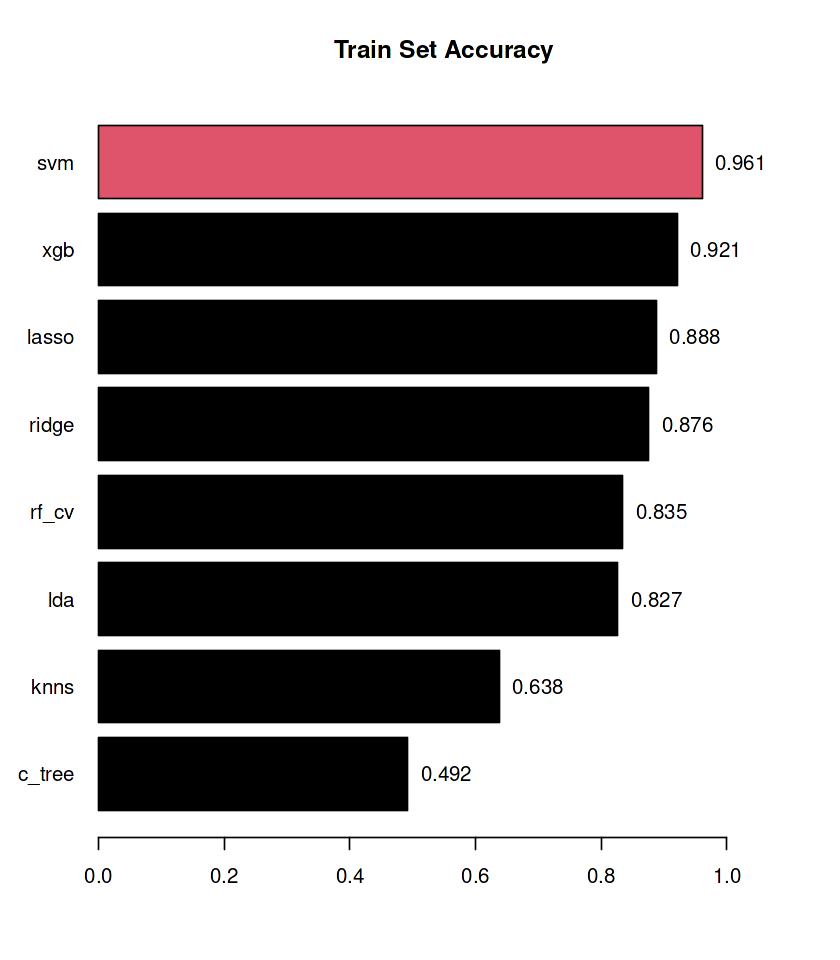

In [38]:
# Create list of caret models
models_caret <- list(c_tree = fit_tree,
                     rf_cv = fit_rf_cv,
                     knns = fit_knns,
                     xgb = fit_xgb,
                     svm = fit_svm,
                     lda = fit_lda)

# Create list of glmnet models 
models_glmnet <- list(lasso = fit_lasso, 
                      ridge = fit_ridge)

# calculate accuracies for all models 
accuracies_caret <- sapply(models_caret, acc_caret)
accuracies_glmnet <- sapply(models_glmnet, acc_glmnet)

# merge model accuracies
accuracies <- c(accuracies_caret, accuracies_glmnet) %>%
                sort()

# Plot model accuracies
options(repr.plot.width = 7)
pos = barplot(accuracies, 
              col = (accuracies == max(accuracies)) + 1, 
              horiz = TRUE, las = 1, xlim = c(0,1.1), main = "Train Set Accuracy") 
text(accuracies + strwidth("__0.000"), pos, round(accuracies,3))

## 5.11 Final model 

Based on the model comparison above, we chose the **support vector machine** as our final model. Hence, we fitted this model on the full training data set to use for our predictions.

In [39]:
# Support vector machine on all data 
fit_svm_final <- train(x = all_features, 
                       y = y, 
                       method = "svmRadial", 
                       trCntrl = trCntrl,
                       preProcess = c("center","scale"), 
                       tuneLength = 10)

# View model
fit_svm_final

Support Vector Machines with Radial Basis Function Kernel 

2538 samples
 882 predictor
   4 classes: 'anger', 'disgust', 'happy', 'sad' 

Pre-processing: centered (882), scaled (882) 
Resampling: Bootstrapped (25 reps) 
Summary of sample sizes: 2538, 2538, 2538, 2538, 2538, 2538, ... 
Resampling results across tuning parameters:

  C       Accuracy   Kappa    
    0.25  0.7651106  0.6699284
    0.50  0.8424622  0.7812584
    1.00  0.8880430  0.8452404
    2.00  0.9187018  0.8878485
    4.00  0.9345623  0.9098355
    8.00  0.9389206  0.9158823
   16.00  0.9387252  0.9156273
   32.00  0.9385528  0.9153867
   64.00  0.9385528  0.9153867
  128.00  0.9385528  0.9153867

Tuning parameter 'sigma' was held constant at a value of 0.0006930483
Accuracy was used to select the optimal model using the largest value.
The final values used for the model were sigma = 0.0006930483 and C = 8.

# 6. Formatting the submission file

Since the SVM model with radial kernel performed best, we used that model to make predicitons on the test data. Below we converted these in the requested format for submission. 

In [40]:
## Make predictions
pred_final = predict(fit_svm_final, all_features_test)

## Write to file
tibble(file = rownames(X_test), category = pred_final) %>% 
    write_csv(path = "submission_svm.csv")

## Check result
cat(readLines("submission_svm.csv",n=20), sep="\n")

Warning message:
“The `path` argument of `write_csv()` is deprecated as of readr 1.4.0.
ℹ Please use the `file` argument instead.”


file,category
S010_004_00000017a.png,anger
S010_004_00000017b.png,anger
S010_004_00000017c.png,anger
S010_004_00000017d.png,anger
S010_004_00000017e.png,anger
S010_004_00000017f.png,anger
S011_002_00000022a.png,sad
S011_002_00000022b.png,sad
S011_002_00000022c.png,sad
S011_002_00000022d.png,sad
S011_002_00000022e.png,sad
S011_002_00000022f.png,sad
S011_005_00000018a.png,disgust
S011_005_00000018b.png,disgust
S011_005_00000018c.png,disgust
S011_005_00000018d.png,disgust
S011_005_00000018e.png,disgust
S011_005_00000018f.png,disgust
S011_006_00000013a.png,happy


# 7. Division of labor

For round 2 of the competition we split our efforts into different feedback points from the first round. We had been running our models on pixel and calculated feature data seperately and were advised to combine these. However, due to the thousands of features we had we first needed to reduce feature number. These tasks were brainstormed together, but then coded by Alex. Another point of inquiry was how we decide our threshold for near zero variance and high correlations. This again was brain stormed together, and the code was adjusted by Lisa. Lastly, we wanted to implement some additional models that we had previously run into issues with, namely LDA and SVM. This code was implemented by Romy. We communicated progress and problem solved together throughout this process.